# Optimistic Gradient Descent in a Bilinear Min-Max Problem

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/google-deepmind/optax/blob/main/examples/ogda_example.ipynb)



In [1]:
import functools
import jax
import optax
import matplotlib.pyplot as plt
from jax import lax, numpy as jnp

Consider the following min-max problem:

$$
\min_{x \in \mathbb R^m} \max_{y\in\mathbb R^n} f(x,y),
$$

where $f: \mathbb R^m \times \mathbb R^n \to \mathbb R$ is a convex-concave function. The solution to such a problem is a saddle-point $(x^\star, y^\star)\in \mathbb R^m \times \mathbb R^n$ such that

$$
f(x^\star, y) \leq f(x^\star, y^\star) \leq f(x, y^\star).
$$

Standard gradient descent-ascent (GDA) updates $x$ and $y$ according to the following update rule at step $k$: 

$$
x_{k+1} = x_k - \eta_k \nabla_x f(x_k, y_k) \\
y_{k+1} = y_k + \eta_k \nabla_y f(x_k, y_k),
$$

where $\eta_k$ is a step size. However, it's well-documented that GDA can fail to converge in this setting. This is an important issue because gradient-based min-max optimization is increasingly prevalent in machine learning (e.g., GANs, constrained RL). *Optimistic* GDA (OGDA) addresses this shortcoming by introducing a form of memory-based negative momentum:  

$$
x_{k+1} = x_k - 2 \eta_k \nabla_x f(x_k, y_k) + \eta_k  \nabla_x f(x_{k-1}, y_{k-1})  \\
y_{k+1} = y_k + 2 \eta_k \nabla_y f(x_k, y_k) - \eta_k \nabla_y f(x_{k-1}, y_{k-1})).
$$

Thus, to implement OGD (or OGA), the optimizer needs to keep track of the gradient from the previous step. OGDA has been formally shown to converge to the optimum $(x_k, y_k) \to (x^\star, y^\star)$ in this setting. The generalised form of the OGDA update rule is given by

$$
x_{k+1} = x_k - (\alpha + \beta) \eta_k \nabla_x f(x_k, y_k) + \beta \eta_k \nabla_x f(x_{k-1}, y_{k-1})  \\
y_{k+1} = y_k + (\alpha + \beta) \eta_k \nabla_y f(x_k, y_k) - \beta \eta_k \nabla_y f(x_{k-1}, y_{k-1})),
$$

which recovers standard OGDA when $\alpha=\beta=1$. See [Mokhtari et al., 2019](https://arxiv.org/abs/1901.08511v2) for more details. 

$$
\pi^{k+1} = \pi^k - \tau_\pi^k \nabla_\pi \mathcal L(\pi^k, \mu^k) \\
\mu^{k+1} = \mu^k + \tau_\mu^k \nabla_\mu \mathcal L(\pi^k_k, \mu^k),
$$

$$
\pi^{k+1} = \pi^k - 2\tau_\pi^k \nabla_\pi \mathcal L(\pi^k, \mu^k) +  \tau_\pi^k \nabla_\pi \mathcal L(\pi^{k-1}, \mu^{k-1})\\
\mu^{k+1} = \mu^k + 2\tau_\mu^k \nabla_\mu \mathcal L(\pi^k_k, \mu^k)+  \tau_\mu^k \nabla_\mu \mathcal L(\pi^{k-1}, \mu^{k-1})
$$

where $\eta_k$ is a step size. However, it's well-documented that GDA can fail to converge in this setting. This is an important issue because gradient-based min-max optimization is increasingly prevalent in machine learning (e.g., GANs, constrained RL). *Optimistic* GDA (OGDA) addresses this shortcoming by introducing a form of memory-based negative momentum:

$$
x_{k+1} = x_k - 2 \eta_k \nabla_x f(x_k, y_k) + \eta_k  \nabla_x f(x_{k-1}, y_{k-1})  \\
y_{k+1} = y_k + 2 \eta_k \nabla_y f(x_k, y_k) - \eta_k \nabla_y f(x_{k-1}, y_{k-1})).
$$

We will now show an example.
First, we define our function $f$:

In [2]:
def f(params):
    x, y = params
    return x * y

Second, we define our helper functions:

In [3]:
def update(optimizer, state, _):
    params, opt_state = state
    grads = jax.grad(f)(params)
    grads = grads.at[1].apply(jnp.negative)
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return (new_params, new_opt_state), params

def optimize(optimizer, params, iters):
    opt_state = optimizer.init(params)
    _, params_hist = lax.scan(functools.partial(update, optimizer), (params, opt_state), length=iters)
    return params_hist

Third, we run our optimizers and plot the results.

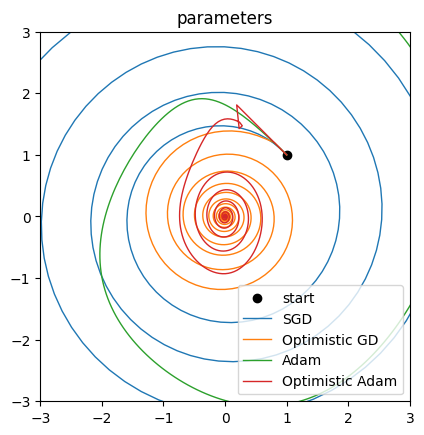

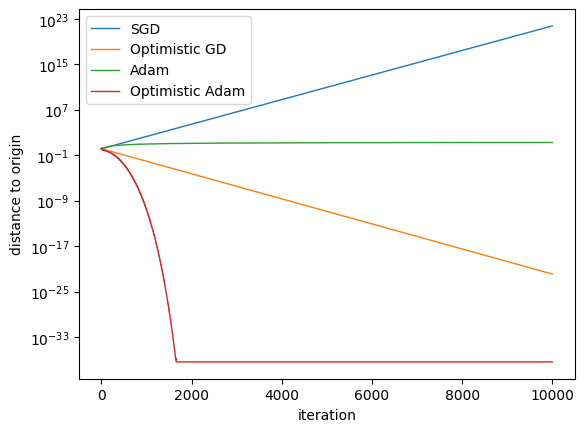

In [5]:
_, ax_params = plt.subplots()
_, ax_distances = plt.subplots()

params = jnp.array([1.0, 1.0])
ax_params.scatter(*params, label="start", color="black")

for label, optimizer in [
    ("SGD", optax.sgd(0.1)),
    ("Optimistic GD", optax.optimistic_gradient_descent(0.1)),
    ("Adam", optax.adam(0.05, nesterov=True)),
    ("Optimistic Adam", optax.optimistic_adam(0.05, 0.5, nesterov=True)),
]:
    params_hist = optimize(optimizer, params, 10**4)
    distances_to_origin = jnp.hypot(*params_hist.T)
    ax_params.plot(*params_hist.T, label=label, lw=1)
    ax_distances.plot(distances_to_origin, label=label, lw=1)

ax_params.legend()
ax_distances.legend()
ax_params.set(title="parameters", aspect="equal", xlim=(-3, 3), ylim=(-3, 3))
ax_distances.set(xlabel="iteration", ylabel="distance to origin", yscale="log")
plt.show()